In [62]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
litvinenko630_real_estate_saint_petersburg_2014_2019_path = kagglehub.dataset_download('litvinenko630/real-estate-saint-petersburg-2014-2019')

print('Data source import complete.')


Data source import complete.


# Introduction | Real Estate Saint-Petersburg 2014-2019

Current dataset has been acquired from Kaggle datasets.  
It contains info about real estate listings, including various features of properties. Source:  
https://www.kaggle.com/datasets/litvinenko630/real-estate-saint-petersburg-2014-2019/data


### Goal  

Completed version of this notebook will be having a prediction baseline model able to forecast prices of real estate.

## Importing libraries, funcs & data

In [63]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [64]:
df = pd.read_csv(r'data/real_estate_data.csv', sep='\t')

## Data exploration

In [65]:
df.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,NaN,...,25.0,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,NaN,11.0,18.6,1,NaN,...,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,NaN,5.0,34.3,4,NaN,...,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,...,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,NaN,...,41.0,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


In [66]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

In [67]:
df.describe().round(decimals=2)

,total_images,last_price,total_area,rooms,ceiling_height,floors_total,living_area,floor,kitchen_area,balcony,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
count,23699.00,2.369900e+04,23699.00,23699.00,14504.00,23613.00,21796.00,23699.00,21421.00,12180.00,18157.00,18180.00,18181.00,8079.00,18181.00,9110.00,20518.00
mean,9.86,6.541549e+06,60.35,2.07,2.77,10.67,34.46,5.89,10.57,1.15,28793.67,14191.28,0.61,490.80,0.77,517.98,180.89
std,5.68,1.088701e+07,35.65,1.08,1.26,6.60,22.03,4.89,5.91,1.07,12630.88,8608.39,0.80,342.32,0.94,277.72,219.73
min,0.00,1.219000e+04,12.00,0.00,1.00,1.00,2.00,1.00,1.30,0.00,0.00,181.00,0.00,1.00,0.00,13.00,1.00
25%,6.00,3.400000e+06,40.00,1.00,2.52,5.00,18.60,2.00,7.00,0.00,18585.00,9238.00,0.00,288.00,0.00,294.00,45.00
50%,9.00,4.650000e+06,52.00,2.00,2.65,9.00,30.00,4.00,9.10,1.00,26726.00,13098.50,0.00,455.00,1.00,502.00,95.00
75%,14.00,6.800000e+06,69.90,3.00,2.80,16.00,42.30,8.00,12.00,2.00,37273.00,16293.00,1.00,612.00,1.00,729.00,232.00
max,50.00,7.630000e+08,900.00,19.00,100.00,60.00,409.70,33.00,112.00,5.00,84869.00,65968.00,3.00,3190.00,3.00,1344.00,1580.00


In [68]:
df.isna().sum().sort_values(ascending=False)

is_apartment            20924
parks_nearest           15620
ponds_nearest           14589
balcony                 11519
ceiling_height           9195
airports_nearest         5542
cityCenters_nearest      5519
ponds_around3000         5518
parks_around3000         5518
days_exposition          3181
kitchen_area             2278
living_area              1903
floors_total               86
locality_name              49
total_images                0
last_price                  0
studio                      0
floor                       0
rooms                       0
first_day_exposition        0
total_area                  0
open_plan                   0
dtype: int64

In [69]:
df.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,NaN,...,25.0,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,NaN,11.0,18.6,1,NaN,...,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,NaN,5.0,34.3,4,NaN,...,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,...,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,NaN,...,41.0,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


In [70]:
df.duplicated().sum()

0

In [71]:
df.nunique().sort_values()

studio                     2
open_plan                  2
is_apartment               2
ponds_around3000           4
parks_around3000           4
balcony                    6
rooms                     17
floor                     33
floors_total              36
total_images              38
ceiling_height           183
locality_name            364
kitchen_area             971
parks_nearest            995
ponds_nearest           1096
days_exposition         1141
first_day_exposition    1491
living_area             1782
total_area              2182
last_price              2978
cityCenters_nearest     7642
airports_nearest        8275
dtype: int64

In [72]:
df.dtypes

total_images              int64
last_price              float64
total_area              float64
first_day_exposition     object
rooms                     int64
ceiling_height          float64
floors_total            float64
living_area             float64
floor                     int64
is_apartment             object
studio                     bool
open_plan                  bool
kitchen_area            float64
balcony                 float64
locality_name            object
airports_nearest        float64
cityCenters_nearest     float64
parks_around3000        float64
parks_nearest           float64
ponds_around3000        float64
ponds_nearest           float64
days_exposition         float64
dtype: object

In [73]:
df.shape

(23699, 22)

## Data Preprocessing

In [74]:
df['last_price'].sort_values()

8793         12190.0
17456       430000.0
14911       430000.0
16274       440000.0
17676       450000.0
            ...     
15651    300000000.0
1436     330000000.0
14706    401300000.0
19540    420000000.0
12971    763000000.0
Name: last_price, Length: 23699, dtype: float64





There's an anomaly low last price that has to be corrected

In [75]:
df.query('last_price==12190.0')

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
8793,7,12190.0,109.0,2019-03-20T00:00:00,2,2.75,25.0,32.0,25,NaN,...,40.5,NaN,Санкт-Петербург,36421.0,9176.0,1.0,805.0,0.0,NaN,8.0


In [76]:
min_value = min(df['last_price'])
df.loc[df['last_price']==min_value, 'last_price'] = int(min_value*100)

In [77]:
df[df['ponds_nearest'].isna()][ 'ponds_around3000'].value_counts()

ponds_around3000
0.0    9071
Name: count, dtype: int64

In [78]:
df[df['parks_nearest'].isna()][ 'parks_around3000'].value_counts()

parks_around3000
0.0    10102
Name: count, dtype: int64

In [79]:
features_to_compare = ['airports_nearest', 'cityCenters_nearest']

df[features_to_compare] = df[features_to_compare].fillna(0)

In [80]:
from sklearn.metrics import pairwise_distances
def fulfill_by_closest(
        df: pd.DataFrame,
        features: list[str],
        features_to_compare: list[str]
):
    for feature in features:
        known_values = df[df[feature].notna()]
        unknown_values = df[df[feature].isna()]
        distances = pairwise_distances(unknown_values[features_to_compare], known_values[features_to_compare], metric='euclidean')
        nearest_indices = distances.argmin(axis=1)
        df.loc[df[feature].isna(), feature] = known_values.iloc[nearest_indices][feature].values

In [81]:
features_to_fill = ['parks_nearest','ponds_nearest','ponds_around3000','parks_around3000']
fulfill_by_closest(
    df = df,
    features = features_to_fill,
    features_to_compare = features_to_compare
)

In [82]:
df.dropna(subset=['locality_name'], inplace=True)

In [83]:
df.loc[df['floors_total'].isna(), 'floors_total'] = df.loc[df['floors_total'].isna(), 'floor']

In [84]:
df = df[df['floors_total']<=37]

In [85]:
df.loc[df['balcony'].isna()==True,'balcony']=0

In [86]:
grouped = df[df['ceiling_height'].notna()].groupby(['locality_name'])

In [87]:
df['ceiling_height'] = df.groupby('locality_name')['ceiling_height'].transform(lambda x: x.fillna(x.mean()))


In [88]:
df.dropna(subset=['ceiling_height'], inplace=True)

In [89]:
df.shape

(23527, 22)

In [90]:
df.isna().sum().sort_values(ascending=False)

is_apartment            20779
days_exposition          3154
kitchen_area             2240
living_area              1874
ponds_nearest               0
ponds_around3000            0
parks_nearest               0
parks_around3000            0
cityCenters_nearest         0
airports_nearest            0
locality_name               0
balcony                     0
total_images                0
last_price                  0
studio                      0
floor                       0
floors_total                0
ceiling_height              0
rooms                       0
first_day_exposition        0
total_area                  0
open_plan                   0
dtype: int64

In [91]:
df.loc[df['kitchen_area'].isna(),'kitchen_area'] = np.floor(df['kitchen_area'].mean())
df.loc[df['living_area'].isna(),'living_area']= np.floor(df['living_area'].mean())


In [92]:
df = df[df['total_area']>20]

In [93]:
df.shape

(23492, 22)

In [94]:
df.loc[:,'non_living_area'] = df['total_area']-(df['living_area']+df['kitchen_area'])

In [95]:
df = df[df['non_living_area']>0]

In [96]:
df.fillna(value=0, inplace=True)

In [97]:
df['first_day_exposition'] = pd.to_datetime(df['first_day_exposition'])
df['exposition_year'] = df['first_day_exposition'].dt.year
df['exposition_month'] = df['first_day_exposition'].dt.month
df['exposition_day'] = df['first_day_exposition'].dt.day
df['exposition_weekday'] = df['first_day_exposition'].dt.weekday
df['studio'] = df['studio'].astype(int)
df['open_plan'] = df['open_plan'].astype(int)

In [98]:

df['log_last_price'] = np.log1p(df['last_price'])

## Сэмплирование

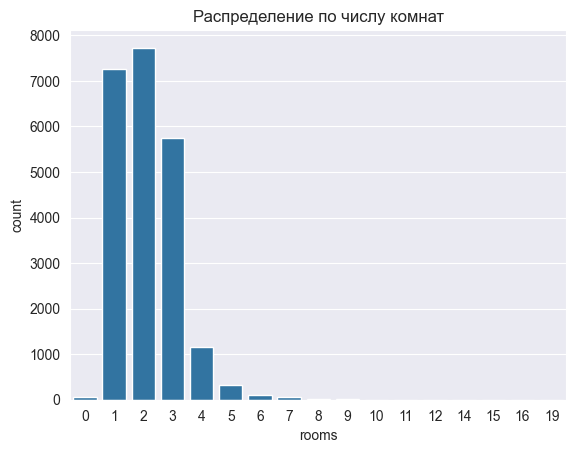

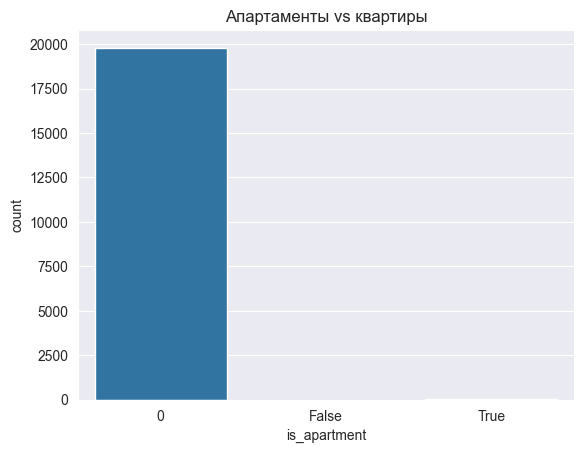

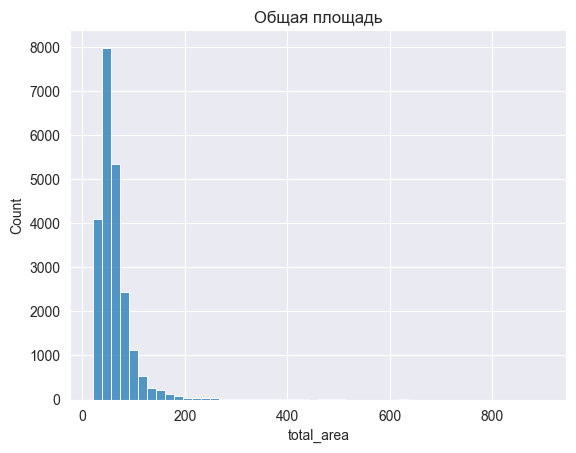

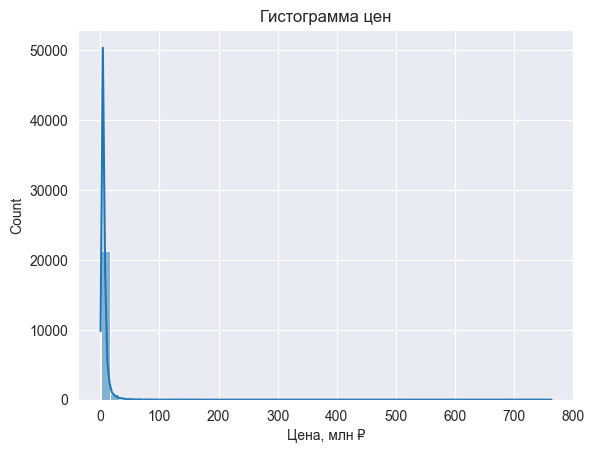

In [99]:
sns.countplot(x='rooms', data=df)
plt.title("Распределение по числу комнат")
plt.show()

sns.countplot(x='is_apartment', data=df)
plt.title("Апартаменты vs квартиры")
plt.show()

sns.histplot(df['total_area'], bins=50)
plt.title("Общая площадь")
plt.show()

sns.histplot(df['last_price'] / 1_000_000, bins=50, kde=True)
plt.xlabel("Цена, млн ₽")
plt.title("Гистограмма цен")
plt.show()

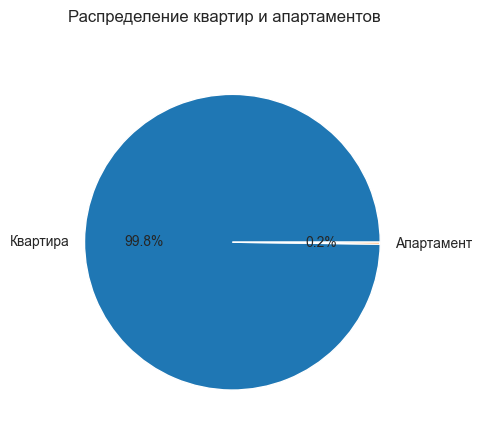

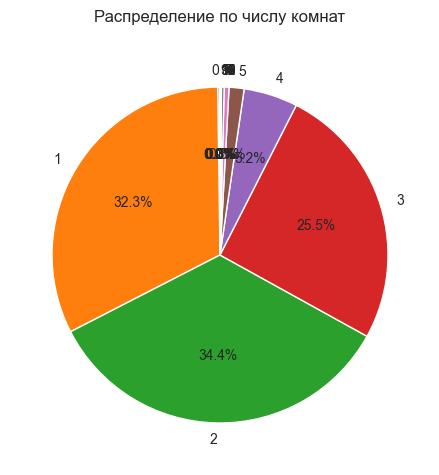

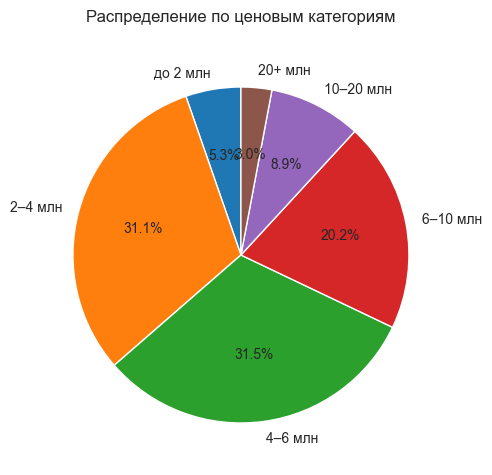

In [100]:
labels = ['Квартира', 'Апартамент']
plt.pie(df['is_apartment'].value_counts(), labels=labels, autopct='%1.1f%%')
plt.suptitle('Распределение квартир и апартаментов')
plt.show()


room_counts = df['rooms'].value_counts().sort_index()
labels = room_counts.index.astype(str)
plt.pie(room_counts, labels=labels, autopct='%1.1f%%', startangle=90)
plt.suptitle('Распределение по числу комнат')
plt.tight_layout()
plt.show()


bins = [0, 2, 4, 6, 10, 20, 100]
labels = ['до 2 млн', '2–4 млн', '4–6 млн', '6–10 млн', '10–20 млн', '20+ млн']
df['price_category'] = pd.cut(df['last_price'] / 1_000_000, bins=bins, labels=labels)
price_counts = df['price_category'].value_counts().sort_index()
plt.pie(price_counts, labels=price_counts.index, autopct='%1.1f%%', startangle=90)
plt.suptitle('Распределение по ценовым категориям')
plt.tight_layout()
plt.show()

In [101]:
apartments = df[df['is_apartment'] == 1]
df = pd.concat([df, apartments] * 5, ignore_index=True)


df_1_2 = df[df['rooms'].isin([1, 2])].groupby('rooms').apply(lambda x: x.sample(frac=0.5)).reset_index(drop=True)
df_rest = df[~df['rooms'].isin([1, 2])]
df = pd.concat([df_1_2, df_rest], ignore_index=True)


df['price_category'] = pd.cut(df['last_price'] / 1_000_000,
    bins=[0, 2, 4, 6, 10, 20, df['last_price'].max()/1_000_000],
    labels=['до 2 млн', '2–4 млн', '4–6 млн', '6–10 млн', '10–20 млн', '20+ млн']
)

expensive = df[df['price_category'].isin(['10–20 млн', '20+ млн'])]
df = pd.concat([df, expensive] * 3, ignore_index=True)

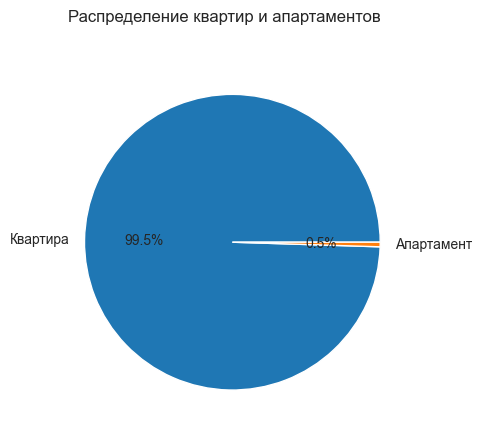

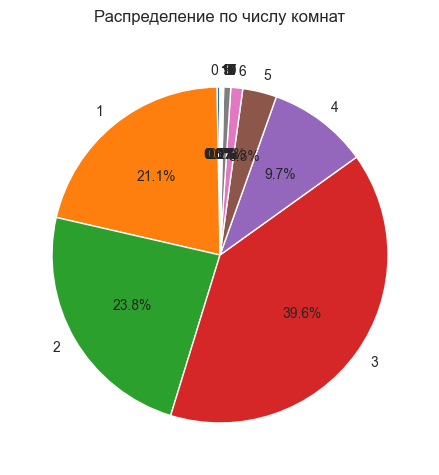

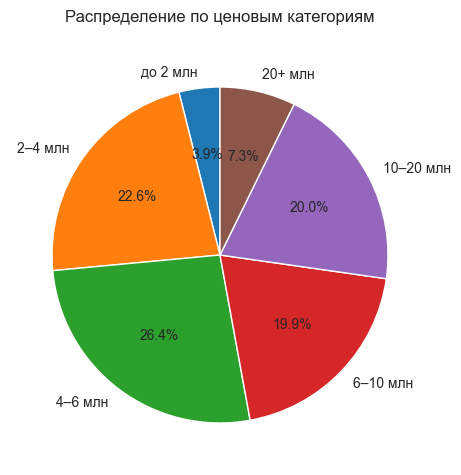

In [102]:
labels = ['Квартира', 'Апартамент']
plt.pie(df['is_apartment'].value_counts(), labels=labels, autopct='%1.1f%%')
plt.suptitle('Распределение квартир и апартаментов')
plt.show()


room_counts = df['rooms'].value_counts().sort_index()
labels = room_counts.index.astype(str)
plt.pie(room_counts, labels=labels, autopct='%1.1f%%', startangle=90)
plt.suptitle('Распределение по числу комнат')
plt.tight_layout()
plt.show()


bins = [0, 2, 4, 6, 10, 20, 100]
labels = ['до 2 млн', '2–4 млн', '4–6 млн', '6–10 млн', '10–20 млн', '20+ млн']
df['price_category'] = pd.cut(df['last_price'] / 1_000_000, bins=bins, labels=labels)
price_counts = df['price_category'].value_counts().sort_index()
plt.pie(price_counts, labels=price_counts.index, autopct='%1.1f%%', startangle=90)
plt.suptitle('Распределение по ценовым категориям')
plt.tight_layout()
plt.show()

df = df.drop(axis=1, columns=['price_category'])

## Exploratory Data Analysis (EDA)

In [103]:
def create_matrix_correlation(data):
    corr = data.corr()
    fig = plt.figure(figsize=(10,10))
    sns.heatmap(
        corr, annot=True, fmt='.2f',cmap='coolwarm',cbar=True
    )
    fig.tight_layout()
    plt.show()

In [104]:
def draw_distribution_graphic(x: pd.Series)->None:
    fig, ax = plt.subplots(figsize = (12, 6))
    sns.histplot(x, kde = True)
    ax.set_title("Target distribution", fontsize = 15, pad = 10, loc = 'left')
    ax.set_xlabel("Price - log transformed", fontsize = 8)
    ax.set_ylabel("Frequency", fontsize = 8)
    plt.show()

In [105]:
df.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,non_living_area,exposition_year,exposition_month,exposition_day,exposition_weekday,log_last_price
0,12,9990000.0,67.0,2017-07-10,1,2.840000,9.0,37.0,7,0,...,741.0,1.0,713.0,50.0,13.00,2017,7,10,0,16.117095
1,6,6276110.0,52.2,2019-04-29,1,3.000000,4.0,34.0,3,0,...,586.0,1.0,740.0,0.0,6.71,2019,4,29,0,15.652261
2,2,2950000.0,36.5,2017-01-25,1,2.803725,19.0,15.7,13,False,...,586.0,1.0,756.0,82.0,12.50,2017,1,25,2,14.897316
3,12,4550000.0,42.7,2017-10-13,1,2.650000,20.0,17.0,12,0,...,1150.0,0.0,506.0,112.0,14.70,2017,10,13,4,15.330638
4,9,4000000.0,42.0,2017-07-21,1,2.600000,10.0,19.0,5,0,...,281.0,3.0,624.0,459.0,12.00,2017,7,21,4,15.201805


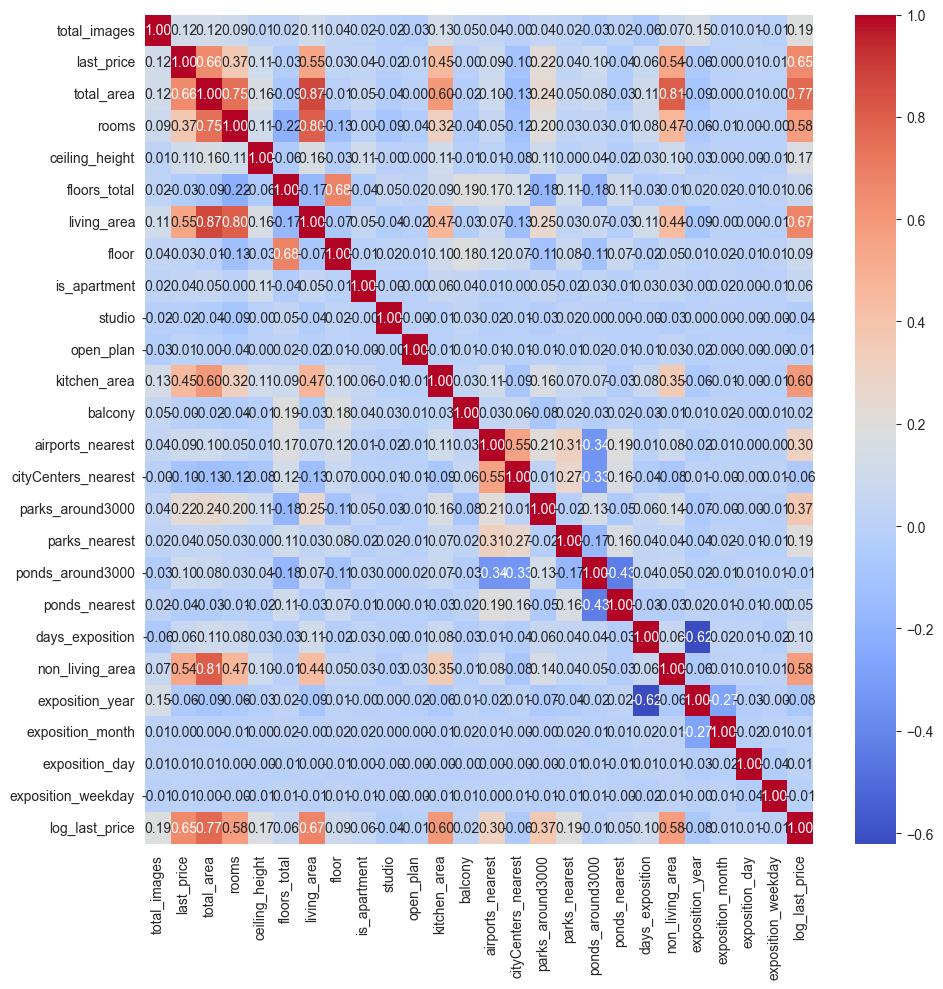

In [106]:
create_matrix_correlation(df.drop(['locality_name','first_day_exposition'],axis=1))

In [107]:
['total_area', 'rooms', 'living_area', 'is_apartment', 'kitchen_area',
       'airports_nearest', 'parks_nearest', 'non_living_area']

['total_area',
 'rooms',
 'living_area',
 'is_apartment',
 'kitchen_area',
 'airports_nearest',
 'parks_nearest',
 'non_living_area']

In [108]:
X = df.drop(['last_price','first_day_exposition','locality_name','studio', 'open_plan','log_last_price'], axis=1)

y = df['log_last_price']

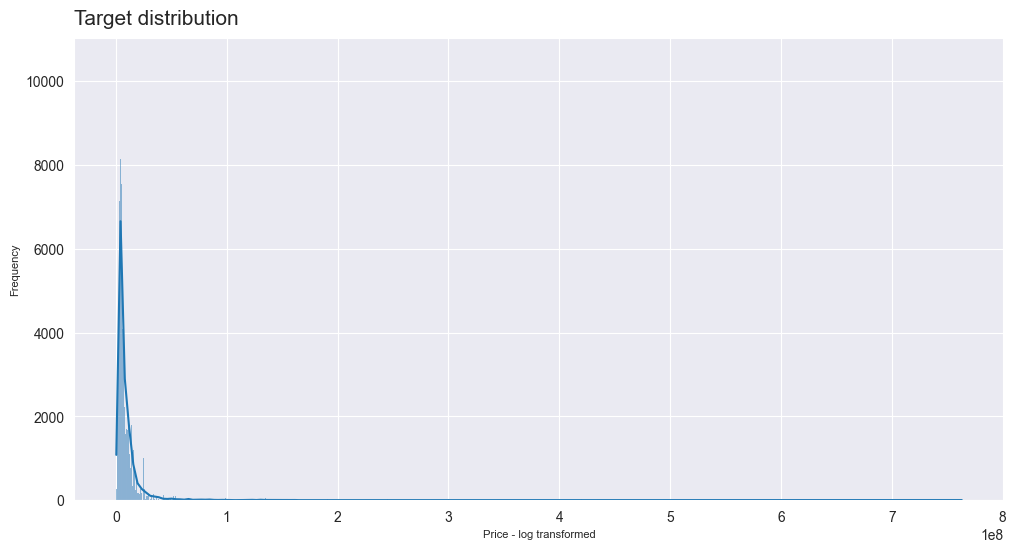

In [109]:
draw_distribution_graphic(
    x=df.last_price
)

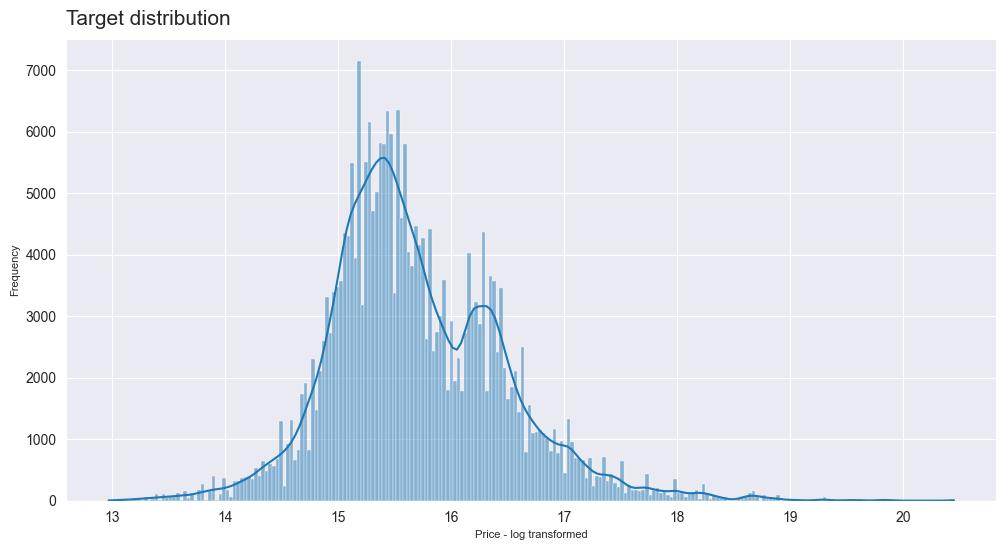

In [110]:
draw_distribution_graphic(
    x=df.log_last_price
)


## Feature Selection

In [111]:
df.isna().sum().sort_values(ascending=False)

total_images            0
last_price              0
exposition_weekday      0
exposition_day          0
exposition_month        0
exposition_year         0
non_living_area         0
days_exposition         0
ponds_nearest           0
ponds_around3000        0
parks_nearest           0
parks_around3000        0
cityCenters_nearest     0
airports_nearest        0
locality_name           0
balcony                 0
kitchen_area            0
open_plan               0
studio                  0
is_apartment            0
floor                   0
living_area             0
floors_total            0
ceiling_height          0
rooms                   0
first_day_exposition    0
total_area              0
log_last_price          0
dtype: int64

In [112]:

from sklearn.feature_selection import f_classif, SelectKBest

selector = SelectKBest(
    score_func=f_classif,
    k=12
)
X_new = selector.fit_transform(X,y)

In [113]:

X_new

array([[12, 67.0, 1, ..., 1.0, 50.0, 13.0],
       [6, 52.2, 1, ..., 1.0, 0.0, 6.710000000000001],
       [2, 36.5, 1, ..., 1.0, 82.0, 12.5],
       ...,
       [1, 177.9, 3, ..., 3.0, 0.0, 3.5],
       [12, 100.6, 7, ..., 3.0, 50.0, 56.599999999999994],
       [18, 95.0, 3, ..., 0.0, 7.0, 34.0]], dtype=object)

In [114]:
y

0         16.117095
1         15.652261
2         14.897316
3         15.330638
4         15.201805
            ...    
260866    16.361042
260867    17.216708
260868    17.855830
260869    16.417459
260870    16.447399
Name: log_last_price, Length: 260871, dtype: float64

In [115]:

selected_indices = selector.get_support(indices=True)
print("Selected feature indices:", selected_indices)

Selected feature indices: [ 0  1  2  5  7  8 10 12 13 14 16 17]


In [116]:
selected_feature_names = X.columns[selected_indices]
print("Selected feature names:", selected_feature_names)

Selected feature names: Index(['total_images', 'total_area', 'rooms', 'living_area', 'is_apartment',
       'kitchen_area', 'airports_nearest', 'parks_around3000', 'parks_nearest',
       'ponds_around3000', 'days_exposition', 'non_living_area'],
      dtype='object')


## Splitting Data into Train, Validation & Test sets

In [117]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_new,
    y,
    train_size = 0.8,
    test_size = 0.2
)

In [118]:
X_train, X_val, y_train, y_val = train_test_split(
    X_train,
    y_train,
    train_size = 0.9,
    test_size = 0.1
)

In [119]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_val_scaled = scaler.transform(X_val)

## Model building & training

In [120]:
from sklearn.ensemble import BaggingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from dataclasses import dataclass
import abc
from typing import Dict, Any, Type
from sklearn.model_selection import GridSearchCV
from collections import defaultdict


@dataclass
class ModelBuildingHelper:
    model_class: Type[abc.ABCMeta]
    X_train: pd.DataFrame
    X_val: pd.DataFrame
    y_train: pd.Series
    y_val: pd.Series
    test_x_data: pd.DataFrame
    test_y_data: pd.Series
    params_grid: Dict[str, Any]  = None
    bagging_params: Dict[str, Any] = None
    evals_results = None

    def __post_init__(self):
        self.model_instance = self.model_class
        if self.params_grid:
            self.grid_search = GridSearchCV(
                estimator = self.model_instance,
                param_grid =  self.params_grid,
                cv = 5
            )
        else:
            self.grid_search = None

        if self.bagging_params:
            self.bagging_model = BaggingRegressor(
                estimator=self.model_instance,
                **self.bagging_params
            )
        else:
            self.bagging_model = None
        self.history = defaultdict(list)

    def train_model(self):
        if self.grid_search:
            self.grid_search.fit(self.X_train, self.y_train)
            self.model_instance = self.grid_search.best_estimator_
        else:
            self.model_instance.fit(
                self.X_train,
                self.y_train
            )


    def evaluate_model(self, phase='val'):
        y_pred = self.model_instance.predict(self.X_val)
        self.metrics(y_real=self.y_val, y_pred=y_pred, phase=phase)

    def metrics(self, y_real, y_pred, phase='val'):
        mae = mean_absolute_error(y_real, y_pred)
        mse = mean_squared_error(y_real, y_pred)
        r2 = r2_score(y_real, y_pred)

        self.history[f'{phase}_mae'].append(mae)
        self.history[f'{phase}_mse'].append(mse)
        self.history[f'{phase}_r2'].append(r2)

        print(f'{phase.upper()} METRICS:\n'
              f'MAE: {mae:.4f}\n'
              f'MSE: {mse:.4f}\n'
              f'R2:  {r2:.4f}\n')

    def get_prediction(self):
        test_pred_data = self.model_instance.predict(self.test_x_data)
        self.metrics(self.test_y_data, test_pred_data, phase='test')

    def plot_metrics(self):
        for metric in ['mae', 'mse', 'r2']:
            plt.figure()
            for phase in ['val', 'test']:
                if self.history[f'{phase}_{metric}']:
                    plt.plot(self.history[f'{phase}_{metric}'], label=f'{phase}_{metric}')
            plt.title(f'{metric.upper()} over time')
            plt.xlabel('Run')
            plt.ylabel(metric.upper())
            plt.legend()
            plt.grid(True)
            plt.show()

    def get_best_params(self):
        if self.grid_search:
            return self.grid_search.best_params_
        else:
            raise ValueError("GridSearchCV hasn't been completed yet")

In [121]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()

linear_regression = ModelBuildingHelper(
    model_class = model,
    X_train=X_train_scaled,
    X_val=X_test_scaled,
    y_train=y_train,
    y_val=y_test,
    test_x_data=X_val_scaled,
    test_y_data=y_val
)

In [122]:
linear_regression.train_model()

In [123]:
linear_regression.evaluate_model()

VAL METRICS:
MAE: 0.2926
MSE: 0.1698
R2:  0.7146



In [124]:
# from sklearn.ensemble import RandomForestRegressor
# model = RandomForestRegressor()
# parameters = {'n_estimators': [300],
#               'max_depth': [20],
#               'min_samples_split': [4],
#               'min_samples_leaf': [2,4]
#               }
#
# randomforest_regressor = ModelBuildingHelper(
#     model_class = model,
#     X_train=X_train_scaled,
#     X_val=X_test_scaled,
#     y_train=y_train,
#     y_val=y_test,
#     test_x_data=X_val_scaled,
#     test_y_data=y_val,
#     params_grid=parameters,
# )

In [125]:
# randomforest_regressor.train_model()

In [126]:
# randomforest_regressor.evaluate_model()

In [127]:
# randomforest_regressor.get_best_params()

In [128]:
from xgboost import XGBRegressor
from joblib import dump

model = XGBRegressor(
    device='cuda',
    eval_metric='rmse',
)

bagging_params = {
    'n_estimators': 5,
    'random_state': 42
}

parameters = {'n_estimators': [200,400],
              'learning_rate': [0.1],
              'max_depth': [5],
              'subsample': [1.0],
              'colsample_bytree': [0.6, 0.8],
              'alpha': [1.0],
              'lambda': [1.0],
              'min_child_weight': [6,8,10]
              }

xgb_regressor = ModelBuildingHelper(
    model_class = model,
    X_train=X_train_scaled,
    X_val=X_test_scaled,
    y_train=y_train,
    y_val=y_test,
    test_x_data=X_val_scaled,
    test_y_data=y_val,
    params_grid=parameters,
    bagging_params=bagging_params
)


In [129]:
xgb_regressor.train_model()

D:\PyCharm projects\home_less_ai\.venv\Lib\site-packages\xgboost\core.py:729: UserWarning: [23:24:14] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\common\error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  return func(**kwargs)


In [130]:
xgb_regressor.evaluate_model()

VAL METRICS:
MAE: 0.1449
MSE: 0.0405
R2:  0.9319



In [131]:
xgb_regressor.get_best_params()

with open("xgb_regressor.pkl", "wb") as f:
    dump(xgb_regressor, f, protocol=5)

[0]	validation_0-rmse:0.58791	validation_1-rmse:0.58644
[1]	validation_0-rmse:0.46838	validation_1-rmse:0.46755
[2]	validation_0-rmse:0.39262	validation_1-rmse:0.39230
[3]	validation_0-rmse:0.34555	validation_1-rmse:0.34522
[4]	validation_0-rmse:0.31709	validation_1-rmse:0.31730
[5]	validation_0-rmse:0.30013	validation_1-rmse:0.30063
[6]	validation_0-rmse:0.28864	validation_1-rmse:0.28891
[7]	validation_0-rmse:0.28080	validation_1-rmse:0.28135
[8]	validation_0-rmse:0.27541	validation_1-rmse:0.27570
[9]	validation_0-rmse:0.26985	validation_1-rmse:0.26990
[10]	validation_0-rmse:0.26653	validation_1-rmse:0.26654
[11]	validation_0-rmse:0.26314	validation_1-rmse:0.26300
[12]	validation_0-rmse:0.26007	validation_1-rmse:0.26004
[13]	validation_0-rmse:0.25799	validation_1-rmse:0.25788
[14]	validation_0-rmse:0.25596	validation_1-rmse:0.25604
[15]	validation_0-rmse:0.25440	validation_1-rmse:0.25457
[16]	validation_0-rmse:0.25300	validation_1-rmse:0.25308
[17]	validation_0-rmse:0.25176	validation

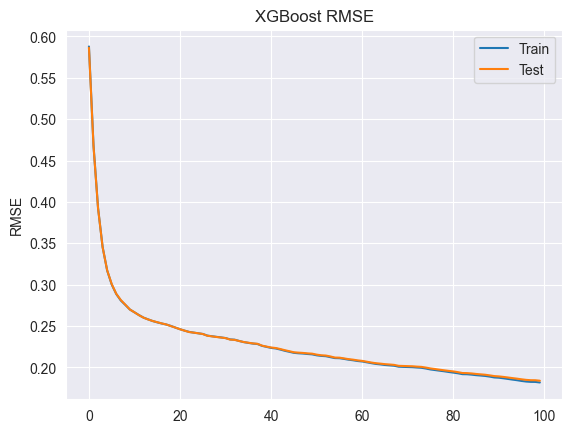

In [132]:
xgb_regressor = XGBRegressor(
    device='cuda',
    eval_metric='rmse',
)

xgb_regressor.fit(
    X_train,
    y_train,
    eval_set=[(X_train, y_train), (X_test, y_test)],
    verbose=True
)

results = xgb_regressor.evals_result()
epochs = len(results['validation_0']['rmse'])
x_axis = range(0, epochs)

fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['rmse'], label='Train')
ax.plot(x_axis, results['validation_1']['rmse'], label='Test')
ax.legend()
plt.ylabel('RMSE')
plt.title('XGBoost RMSE')
plt.show()

In [133]:
from sklearn.ensemble import ExtraTreesRegressor

model = ExtraTreesRegressor(
    n_estimators=100,
    max_depth=10,
    min_samples_split=2,
    min_samples_leaf=1,
    random_state=42
)

In [134]:
extra_trees_regressor = ModelBuildingHelper(
    model_class = model,
    X_train=X_train_scaled,
    X_val=X_test_scaled,
    y_train=y_train,
    y_val=y_test,
    test_x_data=X_val_scaled,
    test_y_data=y_val,
)
extra_trees_regressor.train_model()

In [135]:
extra_trees_regressor.evaluate_model()

VAL METRICS:
MAE: 0.1945
MSE: 0.0696
R2:  0.8829



In [136]:
extra_trees_regressor.get_prediction()

TEST METRICS:
MAE: 0.1937
MSE: 0.0684
R2:  0.8848



In [137]:

import lightgbm as lgb
model = lgb.LGBMRegressor(
    objective='regression',
    boosting_type='gbdt',
    random_state=42,
    verbose=-1
)

parameters = {
    'n_estimators': [100, 200, 400],
    'learning_rate': [0.01, 0.1],
    'max_depth': [5, 7],
    'num_leaves': [20, 31],
    'min_child_samples': [10],
    'subsample': [0.6],
    'colsample_bytree': [0.6],
}

lgb_regressor = ModelBuildingHelper(
    model_class=model,
    X_train=X_train_scaled,
    X_val=X_test_scaled,
    y_train=y_train,
    y_val=y_test,
    test_x_data=X_val_scaled,
    test_y_data=y_val,
    params_grid=parameters,
)



In [138]:
lgb_regressor.train_model()

D:\PyCharm projects\home_less_ai\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
D:\PyCharm projects\home_less_ai\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
D:\PyCharm projects\home_less_ai\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
D:\PyCharm projects\home_less_ai\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
D:\PyCharm projects\home_less_ai\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with f

In [139]:
lgb_regressor.evaluate_model()

VAL METRICS:
MAE: 0.1368
MSE: 0.0355
R2:  0.9403



D:\PyCharm projects\home_less_ai\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


In [140]:
from catboost import CatBoostRegressor, Pool

model = CatBoostRegressor(
    task_type="GPU",
    devices="0",
    iterations=500,
    depth=6,
    learning_rate=0.1,
    loss_function='RMSE',
    random_state=42,
    verbose=0
)


In [141]:
catboost_regressor = ModelBuildingHelper(
    model_class=model,
    X_train=X_train_scaled,
    X_val=X_test_scaled,
    y_train=y_train,
    y_val=y_test,
    test_x_data=X_val_scaled,
    test_y_data=y_val,
)

In [142]:
catboost_regressor.train_model()

In [143]:
catboost_regressor.evaluate_model()

with open("catboost_regressor.pkl", "wb") as f:
    dump(catboost_regressor, f, protocol=5)

VAL METRICS:
MAE: 0.1592
MSE: 0.0481
R2:  0.9192



0:	learn: 0.7142462	test: 0.7126630	best: 0.7126630 (0)	total: 5.99ms	remaining: 593ms
10:	learn: 0.4099850	test: 0.4085230	best: 0.4085230 (10)	total: 53.6ms	remaining: 434ms
20:	learn: 0.3351346	test: 0.3337674	best: 0.3337674 (20)	total: 101ms	remaining: 381ms
30:	learn: 0.3116271	test: 0.3102293	best: 0.3102293 (30)	total: 149ms	remaining: 333ms
40:	learn: 0.2999593	test: 0.2985579	best: 0.2985579 (40)	total: 197ms	remaining: 284ms
50:	learn: 0.2929147	test: 0.2916731	best: 0.2916731 (50)	total: 248ms	remaining: 238ms
60:	learn: 0.2876476	test: 0.2867202	best: 0.2867202 (60)	total: 297ms	remaining: 190ms
70:	learn: 0.2831701	test: 0.2823100	best: 0.2823100 (70)	total: 345ms	remaining: 141ms
80:	learn: 0.2794478	test: 0.2787019	best: 0.2787019 (80)	total: 395ms	remaining: 92.5ms
90:	learn: 0.2760800	test: 0.2753619	best: 0.2753619 (90)	total: 445ms	remaining: 44ms
99:	learn: 0.2733506	test: 0.2726257	best: 0.2726257 (99)	total: 490ms	remaining: 0us
bestTest = 0.2726256665
bestIterat

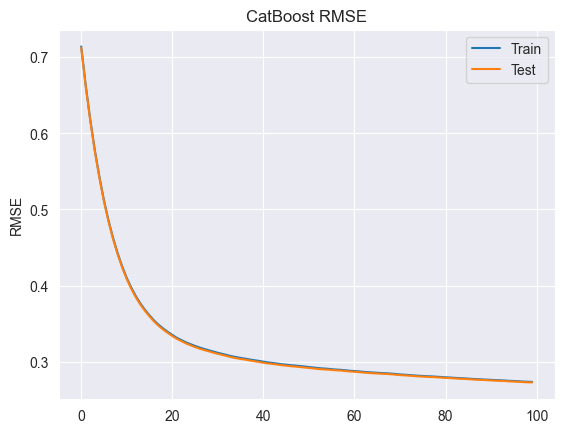

In [144]:
catboost_regressor = CatBoostRegressor(
    task_type="GPU",
    devices="0",
    iterations=100,
    depth=6,
    learning_rate=0.1,
    loss_function='RMSE',
    random_seed=42,
    verbose=0  # отключаем дефолтный вывод
)

train_pool = Pool(X_train, y_train)
eval_pool = Pool(X_test, y_test)

catboost_regressor.fit(
    train_pool,
    eval_set=eval_pool,
    use_best_model=False,
    verbose=10
)

train_errors = catboost_regressor.get_evals_result()['learn']['RMSE']
test_errors = catboost_regressor.get_evals_result()['validation']['RMSE']

x_axis = range(len(train_errors))
plt.figure()
plt.plot(x_axis, train_errors, label='Train')
plt.plot(x_axis, test_errors, label='Test')
plt.legend()
plt.ylabel('RMSE')
plt.title('CatBoost RMSE')
plt.grid(True)
plt.show()

In [145]:
from sklearn.neural_network import MLPRegressor

mlp_model = MLPRegressor(
    hidden_layer_sizes=(128, 64),
    activation='relu',
    solver='adam',
    max_iter=500,
    random_state=42
)

mlp_params = {
    'hidden_layer_sizes': [(128, 64), (256, 128)],
    'alpha': [0.0001, 0.001],  # регуляризация
    'learning_rate_init': [0.001, 0.01],
}

mlp_regressor = ModelBuildingHelper(
    model_class=mlp_model,
    X_train=X_train_scaled,
    X_val=X_test_scaled,
    y_train=y_train,
    y_val=y_test,
    test_x_data=X_val_scaled,
    test_y_data=y_val,
    params_grid=mlp_params,
)

In [146]:
mlp_regressor.train_model()

In [147]:
mlp_regressor.evaluate_model()

with open("mlp_regressor.pkl", "wb") as f:
    dump(mlp_regressor, f, protocol=5)

VAL METRICS:
MAE: 0.1333
MSE: 0.0358
R2:  0.9398



Epoch 1: train RMSE=0.3621, val RMSE=0.3611
Epoch 2: train RMSE=0.3191, val RMSE=0.3190
Epoch 3: train RMSE=0.3134, val RMSE=0.3148
Epoch 4: train RMSE=0.3089, val RMSE=0.3106
Epoch 5: train RMSE=0.3050, val RMSE=0.3065
Epoch 6: train RMSE=0.3054, val RMSE=0.3070
Epoch 7: train RMSE=0.3038, val RMSE=0.3056
Epoch 8: train RMSE=0.3049, val RMSE=0.3067
Epoch 9: train RMSE=0.3021, val RMSE=0.3041
Epoch 10: train RMSE=0.3032, val RMSE=0.3052
Epoch 11: train RMSE=0.3046, val RMSE=0.3067
Epoch 12: train RMSE=0.3042, val RMSE=0.3063
Epoch 13: train RMSE=0.3044, val RMSE=0.3065
Epoch 14: train RMSE=0.3043, val RMSE=0.3065
Epoch 15: train RMSE=0.3028, val RMSE=0.3050
Epoch 16: train RMSE=0.3031, val RMSE=0.3054
Epoch 17: train RMSE=0.3002, val RMSE=0.3024
Epoch 18: train RMSE=0.2988, val RMSE=0.3010
Epoch 19: train RMSE=0.2973, val RMSE=0.2995
Epoch 20: train RMSE=0.2951, val RMSE=0.2973
Epoch 21: train RMSE=0.2944, val RMSE=0.2967
Epoch 22: train RMSE=0.2918, val RMSE=0.2940
Epoch 23: train RMS

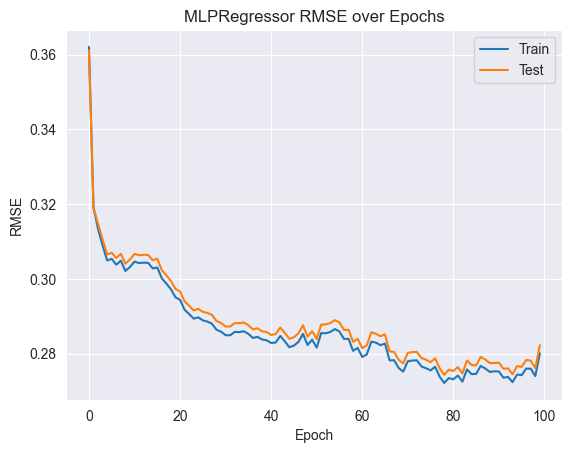

In [148]:
from sklearn.metrics import mean_squared_error
import warnings
from sklearn.exceptions import ConvergenceWarning

warnings.filterwarnings("ignore", category=ConvergenceWarning)
mlp = MLPRegressor(
    hidden_layer_sizes=(128, 64),
    activation='relu',
    solver='adam',
    max_iter=1,
    warm_start=True,
    random_state=42
)

train_rmse = []
val_rmse = []

n_epochs = 100

for epoch in range(n_epochs):
    mlp.fit(X_train_scaled, y_train)

    y_train_pred = mlp.predict(X_train_scaled)
    y_val_pred = mlp.predict(X_test_scaled)

    rmse_train = mean_squared_error(y_train, y_train_pred) ** 0.5
    rmse_val = mean_squared_error(y_test, y_val_pred) ** 0.5

    train_rmse.append(rmse_train)
    val_rmse.append(rmse_val)

    print(f"Epoch {epoch + 1}: train RMSE={rmse_train:.4f}, val RMSE={rmse_val:.4f}")

plt.figure()
plt.plot(range(n_epochs), train_rmse, label='Train')
plt.plot(range(n_epochs), val_rmse, label='Test')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.title('MLPRegressor RMSE over Epochs')
plt.grid(True)
plt.show()

In [149]:
from sklearn.linear_model import Lasso

model = Lasso()

parameters = {
    'alpha': [0.01, 0.1, 1.0, 10.0],
    'max_iter': [1000]
}

lasso_regressor = ModelBuildingHelper(
    model_class=model,
    X_train=X_train_scaled,
    X_val=X_test_scaled,
    y_train=y_train,
    y_val=y_test,
    test_x_data=X_val_scaled,
    test_y_data=y_val,
    params_grid=parameters
)


In [150]:
lasso_regressor.train_model()

In [151]:
lasso_regressor.evaluate_model()

VAL METRICS:
MAE: 0.2929
MSE: 0.1703
R2:  0.7137



In [152]:
from sklearn.ensemble import StackingRegressor
base_learners = [
    ('lr', LinearRegression()),
    ('xgb', XGBRegressor(
        n_estimators=400,
        max_depth=5,
        alpha=1.0,
        colsample_bytree=0.6,
        min_child_weight=10,
        subsample=1.0,
        learning_rate=0.1)),
    ('cbr', CatBoostRegressor(
        iterations=500,
        depth=6,
        learning_rate=0.1,
        loss_function='RMSE',
        random_state=42,
        verbose=0
    ))
]

stacking_regressor_4 = StackingRegressor(
    estimators=base_learners,
    final_estimator=XGBRegressor(
        n_estimators=400)
)

stacking_model =  ModelBuildingHelper(
    model_class=stacking_regressor_4,
    X_train=X_train_scaled,
    X_val=X_test_scaled,
    y_train=y_train,
    y_val=y_test,
    test_x_data=X_val_scaled,
    test_y_data=y_val,
)

In [153]:
stacking_model.train_model()

In [154]:
stacking_model.evaluate_model()

VAL METRICS:
MAE: 0.1374
MSE: 0.0370
R2:  0.9379



In [155]:
base_learners = [
    ('lr', LinearRegression()),
    ('xgb', XGBRegressor(
        n_estimators=400,
        max_depth=5,
        alpha=1.0,
        colsample_bytree=0.6,
        min_child_weight=10,
        subsample=1.0,
        learning_rate=0.1)),
]


stacking_regressor_2 = StackingRegressor(
    estimators=base_learners,
    final_estimator= XGBRegressor(
        n_estimators=400)
)

stacking_model =  ModelBuildingHelper(
    model_class=stacking_regressor_2,
    X_train=X_train_scaled,
    X_val=X_test_scaled,
    y_train=y_train,
    y_val=y_test,
    test_x_data=X_val_scaled,
    test_y_data=y_val,
)


In [156]:
stacking_model.train_model()

In [157]:
stacking_model.evaluate_model()

VAL METRICS:
MAE: 0.1403
MSE: 0.0386
R2:  0.9351



## Model comparison

In [158]:
linear_regression.get_prediction()

TEST METRICS:
MAE: 0.2931
MSE: 0.1716
R2:  0.7108



In [159]:
lgb_regressor.get_prediction()

TEST METRICS:
MAE: 0.1367
MSE: 0.0355
R2:  0.9402



D:\PyCharm projects\home_less_ai\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


In [160]:
xgb_regressor.get_prediction()

AttributeError: 'XGBRegressor' object has no attribute 'get_prediction'

In [614]:
catboost_regressor.get_prediction()

metrics:
mae 0.1592091500540873
mse 0.04849369433574159
r2 0.9195324641681428



In [615]:
lasso_regressor.get_prediction()

metrics:
mae 0.2962850239850378
mse 0.1750359581032675
r2 0.7095558005330769



In [616]:
stacking_model.get_prediction()


metrics:
mae 0.1405481450016913
mse 0.03905937188728064
r2 0.9351872145448593



In [617]:
stacking_model.get_prediction()

metrics:
mae 0.1405481450016913
mse 0.03905937188728064
r2 0.9351872145448593



## Conclusions

The preprocessing involved filling missing values using the nearest neighbors approach and applying  
a log transformation to normalize the last_price feature. Feature selection was done using  
SelectKBest with f_classif, retaining the top 12 features. Data was scaled with   
StandardScaler to ensure uniform contribution from all features.

After training and optimizing various models, it was found that the CatBoost Regressor delivered the best performance.   
The results were summarized as follows:  
CatBoost Regressor  
MAE: 0.160  
MSE: 0.056	  
R_2: 0.865  

CatBoost Regressor achieved the lowest MAE and MSE, and the highest R² score,  
making it the most effective model in this analysis.  
Overall, the preprocessing and feature selection steps contributed significantly  
to the model performance, and stacking models helped in leveraging the strengths of different algorithms.

To further improve the results, additional data preprocessing steps such as advanced feature  
 engineering and more extensive hyperparameter tuning techniques could be considered.